<a href="https://colab.research.google.com/github/MayarAtef16/MayarAtef16/blob/main/Google_Brain_Ventilator_Pressure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [33]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [34]:
! chmod 600 ~/.kaggle/kaggle.json

In [35]:
! kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                              Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23           5319        173  1.0              
surajjha101/stores-area-and-sales-data                                Supermarket store branches sales analysis            10KB  2022-04-29 11:10:16           4886        150  1.0              
devansodariya/student-performance-data                                Student Performance Dataset                           7KB  2022-05-26 13:55:09           1769        102  0.9705882        
paradisejoy/top-hits-spotify-f

In [39]:
!kaggle competitions download -c ventilator-pressure-prediction

 89% 199M/223M [00:01<00:00, 120MB/s]
100% 223M/223M [00:01<00:00, 124MB/s]


In [41]:
!unzip "ventilator-pressure-prediction.zip"

Archive:  ventilator-pressure-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


#Libraries

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold,RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from scipy import stats

#Reading data  

In [43]:
#n = 6,036,000 #number of records in file
raw_data = pd.read_csv("train.csv", index_col = 0)

In [44]:
print(raw_data.dtypes)
raw_data.head()

breath_id      int64
R              int64
C              int64
time_step    float64
u_in         float64
u_out          int64
pressure     float64
dtype: object


,breath_id,R,C,time_step,u_in,u_out,pressure
id,,,,,,,
1,1,20,50,0.000000,0.083334,0,5.837492
2,1,20,50,0.033652,18.383041,0,5.907794
3,1,20,50,0.067514,22.509278,0,7.876254
4,1,20,50,0.101542,22.808822,0,11.742872
5,1,20,50,0.135756,25.355850,0,12.234987


In [45]:
print(raw_data.info())
raw_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6036000 entries, 1 to 6036000
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   breath_id  int64  
 1   R          int64  
 2   C          int64  
 3   time_step  float64
 4   u_in       float64
 5   u_out      int64  
 6   pressure   float64
dtypes: float64(3), int64(4)
memory usage: 368.4 MB
None


,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


#Data Preprocessing

## Removing Outliers

{'boxes': [<matplotlib.lines.Line2D at 0x7f43f4b7d290>],
 'caps': [<matplotlib.lines.Line2D at 0x7f43f4b89350>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f43f4b91390>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f43f4b89e10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f43f4b7d890>,
  <matplotlib.lines.Line2D at 0x7f43f4b7ddd0>]}

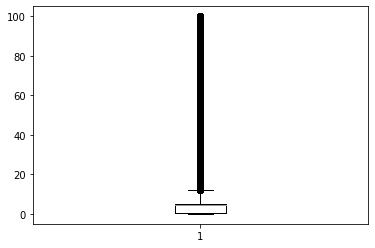

In [46]:
plt.boxplot(raw_data['u_in'], notch=None, vert=None, patch_artist=None, widths=None)

{'boxes': [<matplotlib.lines.Line2D at 0x7f43f4631b10>],
 'caps': [<matplotlib.lines.Line2D at 0x7f43f4636b90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f43f463dbd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f43f463d690>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f43f4636110>,
  <matplotlib.lines.Line2D at 0x7f43f4636650>]}

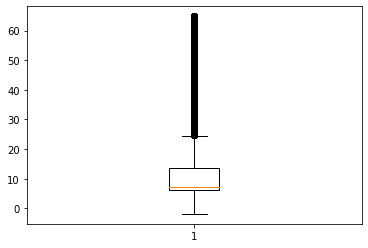

In [47]:
plt.boxplot(raw_data['pressure'], notch=None, vert=None, patch_artist=None, widths=None)

{'boxes': [<matplotlib.lines.Line2D at 0x7f43f45a3fd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f43f45b5050>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f43f45bd090>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f43f45b5b10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f43f45ab590>,
  <matplotlib.lines.Line2D at 0x7f43f45abad0>]}

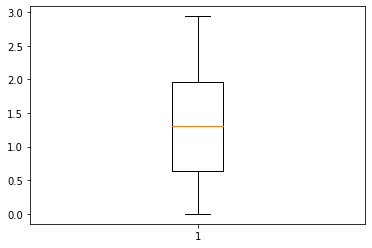

In [48]:
plt.boxplot(raw_data['time_step'], notch=None, vert=None, patch_artist=None, widths=None)

In [49]:
z_scores = stats.zscore(raw_data)

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4).all(axis=1)
filtered_data = raw_data[filtered_entries]

{'boxes': [<matplotlib.lines.Line2D at 0x7f43f4521990>],
 'caps': [<matplotlib.lines.Line2D at 0x7f43f45279d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f43f452da10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f43f452d4d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f43f4521f10>,
  <matplotlib.lines.Line2D at 0x7f43f4527490>]}

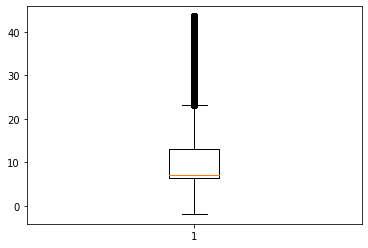

In [50]:
plt.boxplot(filtered_data['pressure'], notch=None, vert=None, patch_artist=None, widths=None)

{'boxes': [<matplotlib.lines.Line2D at 0x7f43f450af10>],
 'caps': [<matplotlib.lines.Line2D at 0x7f43f4497e10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f43f449ee50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f43f449e910>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f43f4497390>,
  <matplotlib.lines.Line2D at 0x7f43f4497910>]}

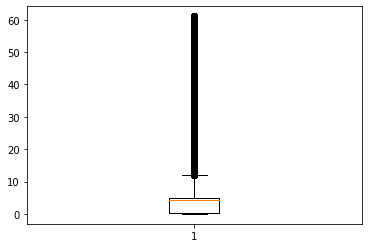

In [51]:
plt.boxplot(filtered_data['u_in'], notch=None, vert=None, patch_artist=None, widths=None)

In [52]:
print(raw_data.isnull().sum())

breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64


In [53]:
print(raw_data.duplicated().sum())

0


breath_id   -0.002
R            0.017
C           -0.048
time_step   -0.528
u_in         0.351
u_out       -0.619
pressure     1.000
Name: pressure, dtype: float64

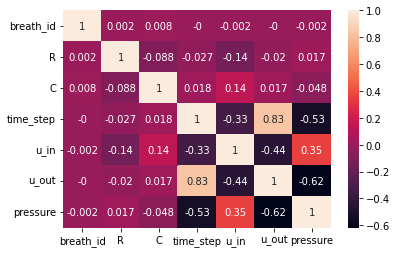

In [54]:
sns.heatmap(filtered_data.corr().round(3), annot=True)
filtered_data.corr().round(3)['pressure']

#Data Spliting

For the sake of time and for the code to run successfully without being interuppted by the limitations of the RAM, we will use random samples of the entire dataset. The polynomial will extremely increase: the processing time 

In [55]:
#Splitting data + preparing data for k_fold cross validation
db_train, db_test = train_test_split(filtered_data, shuffle=False)
db_train = db_train.sample(n=200000, replace = False)
db_test = db_test.sample(n=50000, replace = False)
X_train= pd.DataFrame(data= np.c_[db_train['R'],db_train['C'],db_train['time_step'], db_train['u_in'], db_train['u_out']], columns =['R','C','time_step','u_in','u_out'])
Y_train = db_train['pressure']

X_test = pd.DataFrame(data= np.c_[db_test['R'],db_test['C'],db_test['time_step'], db_test['u_in'], db_test['u_out']], columns =['R','C','time_step','u_in','u_out'])
Y_test = db_test['pressure']

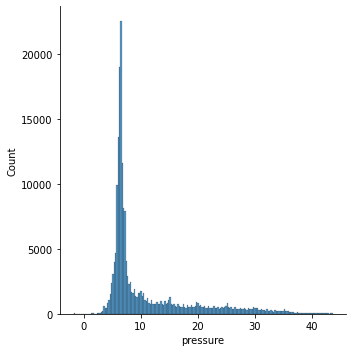

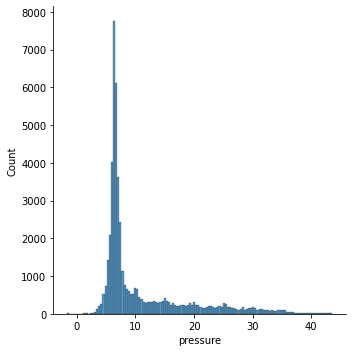

In [56]:
sns.displot(x = Y_train)
sns.displot(x = Y_test)

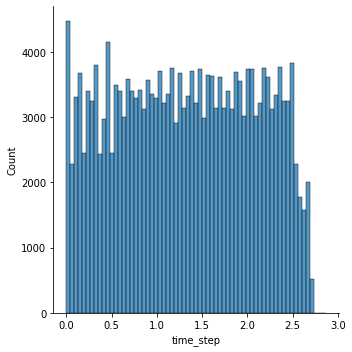

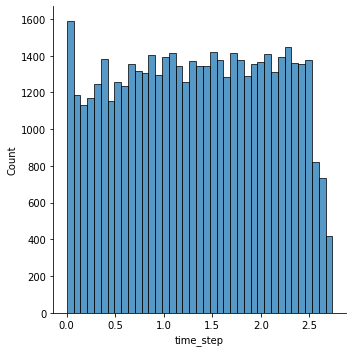

In [57]:
sns.displot(x = X_train["time_step"])
sns.displot(x = X_test["time_step"])

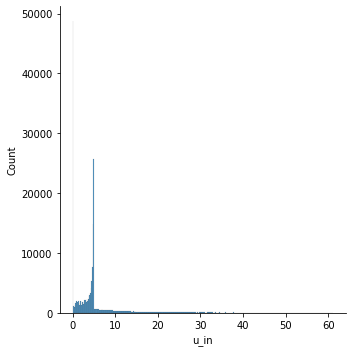

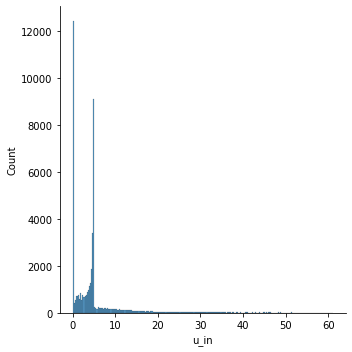

In [58]:
sns.displot(x = X_train["u_in"])
sns.displot(x = X_test["u_in"])

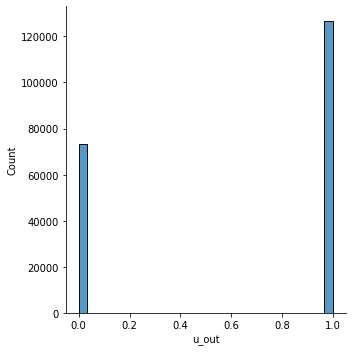

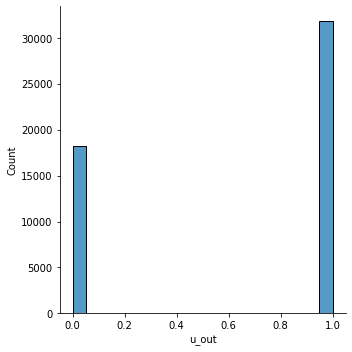

In [59]:
sns.displot(x = X_train["u_out"])
sns.displot(x = X_test["u_out"])

#Feature scaling

In [60]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range =(0, 1))
min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)

#K_fold Cross Validation in Polynomial Regression

In [61]:
cv = KFold(n_splits=10, random_state=None, shuffle=False)
lin_model = LinearRegression()
for i in range(1,7):
    poly = PolynomialFeatures(degree=i)
    X_poly = poly.fit_transform(X_train)
    scores = cross_validate(lin_model, X_poly, Y_train, scoring=("neg_mean_squared_error", "r2"), cv=cv, n_jobs=-1,return_train_score=True)
#0.7250483193778943, 4.104827575928237
    print("For RMSE: Degree:"+str(i)+" polynomial MSE: " + str(np.mean(np.sqrt(np.abs(scores['test_neg_mean_squared_error'])))) + ", STD: " + str(np.sqrt(np.std(scores['test_neg_mean_squared_error']))))
    print("For R2: Degree:"+str(i)+" polynomial R2: " + str(np.mean(scores['train_r2'])) + ", STD: " + str(np.std(scores['train_r2'])))

For RMSE: Degree:1 polynomial MSE: 6.081215442438717, STD: 0.7552599290781492
For R2: Degree:1 polynomial R2: 0.3928397811839222, STD: 0.0005300583768846555
For RMSE: Degree:2 polynomial MSE: 4.979205871500414, STD: 0.7882197067152125
For R2: Degree:2 polynomial R2: 0.5930079519178454, STD: 0.0006311662340360238
For RMSE: Degree:3 polynomial MSE: 4.5930085639167615, STD: 0.7178572686693995
For R2: Degree:3 polynomial R2: 0.6538524413030701, STD: 0.000549264613517496


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


For RMSE: Degree:4 polynomial MSE: 4.371524631884539, STD: 0.6851614325780365
For R2: Degree:4 polynomial R2: 0.6867235404806138, STD: 0.000475347504165896


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


For RMSE: Degree:5 polynomial MSE: 4.227715456280337, STD: 0.6369464021672528
For R2: Degree:5 polynomial R2: 0.7072184785232495, STD: 0.00042336713002295926


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


For RMSE: Degree:6 polynomial MSE: 4.130583317726215, STD: 0.6128464329217619
For R2: Degree:6 polynomial R2: 0.7208598039758816, STD: 0.000468394174147275


#Linear Regression

In [62]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)
lin_model.intercept_, lin_model.coef_

(16.79303596269452,
 array([ 0.25364779, -0.95114584, -1.45838909,  5.51943365, -8.55979225]))

In [63]:
Y_train_predict = lin_model.predict(X_train)
Y_test_predict = lin_model.predict(X_test)

In [64]:
mse_train = mean_squared_error(Y_train,Y_train_predict)
rmse_train = np.sqrt(mse_train)
rmse_train

6.081204874693486

In [65]:
mse_test =mean_squared_error(Y_test,Y_test_predict)
rmse_test = np.sqrt(mse_test)
rmse_test

6.032140996003557

In [66]:
mae_train = mean_absolute_error(Y_train,Y_train_predict)
rmae_train = np.sqrt(mae_train)
mae_train, rmae_train

(3.806038031537015, 1.9509069766488136)

In [67]:
mae_test = mean_absolute_error(Y_test,Y_test_predict)
rmae_test = np.sqrt(mae_test)
mae_test, rmae_test

(3.755317293067302, 1.9378641059339796)

In [68]:
r2_train = r2_score(Y_train,Y_train_predict)
r2_test = r2_score(Y_test,Y_test_predict)
print(r2_train,r2_test)

0.39283821386137663 0.39720237899789423


#Polynomial Regression

#Regularization
-side note: we were forced to regularise the polynomial regression on second degree and not higher since regualrization requires very time consuming processings. However, the second degree polynomial regulartion did achieve better accuracy than that of it's non regularized second order counterpart.

In [69]:
for i in range(1,9):
    print("For degree: ", i)
    poly_feat = PolynomialFeatures(degree = i)
    poly_model = LinearRegression()
    X_train_poly = poly_feat.fit_transform (X_train)
    X_test_poly = poly_feat.transform(X_test)

    poly_model.fit(X_train_poly, Y_train)
    Y_train_poly_predict = poly_model.predict(X_train_poly)
    Y_test_poly_predict = poly_model.predict(X_test_poly)

    print("R2:")
    r2_poly_train = r2_score(Y_train,Y_train_poly_predict)
    r2_poly_test = r2_score(Y_test,Y_test_poly_predict)
    print("   ",r2_poly_train,r2_poly_test)
    print("MSE:")
    mse_poly_train = mean_squared_error(Y_train,Y_train_poly_predict)
    mse_poly_test = mean_squared_error(Y_test,Y_test_poly_predict)
    rmse_poly_train = np.sqrt(mse_poly_train)
    rmse_poly_test = np.sqrt(mse_poly_test)
    print("   ",rmse_poly_train,rmse_poly_test)

    print("MAE:")
    mae_train = mean_absolute_error(Y_train,Y_train_poly_predict)
    mae_test = mean_absolute_error(Y_test,Y_test_poly_predict)
    rmae_test = np.sqrt(mae_test)
    print("   ",mae_train,mae_test)

For degree:  1
R2:
    0.39283821386137663 0.397202378997894
MSE:
    6.081204874693486 6.032140996003558
MAE:
    3.8060380315370126 3.755317293067299
For degree:  2
R2:
    0.5930016324864976 0.5944917991777479
MSE:
    4.978904012263258 4.947497007691853
MAE:
    2.9898848194011314 2.959485856368595
For degree:  3
R2:
    0.6538402395111331 0.6549848185021243
MSE:
    4.591723316172987 4.563571110135557
MAE:
    2.6758968781189174 2.6476742952448538
For degree:  4
R2:
    0.6866976954076215 0.6875976305499005
MSE:
    4.368367976721978 4.3425305156700125
MAE:
    2.452189309447411 2.430824481170826
For degree:  5
R2:
    0.7071834240849706 0.707944546588134
MSE:
    4.223137764564093 4.19873416933878
MAE:
    2.3169015897477347 2.2994448135956955
For degree:  6
R2:
    0.7208162656036929 0.7208180234149214
MSE:
    4.123656449008734 4.105153569393231
MAE:
    2.2205557260101467 2.2072345375826634
For degree:  7
R2:
    0.729404016594027 0.730036602261259
MSE:
    4.059738805486798 4

In [70]:
poly_feat = PolynomialFeatures(degree = 2)
X_train_poly = poly_feat.fit_transform (X_train)

ridge = Ridge(solver = 'saga')
params = {'alpha' : [1e-5,1e-4,1e-3,1e-2,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5,10,20,30,40,50,100,200,300,400,500]}
Regressor = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv = 10)
Regressor.fit(X_train_poly, Y_train)

print("Best hyperparameter is :", Regressor.best_params_ , " with RMSE of : ", np.sqrt(np.abs(Regressor.best_score_)))


Best hyperparameter is : {'alpha': 0.3}  with RMSE of :  4.979586443180598


In [71]:
lasso = Lasso()
params = {'alpha' : [1e-5,1e-4,1e-3,1e-2,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5,10,20,30,40,50,100,200,300,400,500]}
Regressor = GridSearchCV(lasso, params, scoring='neg_mean_squared_error', cv = 10)
Regressor.fit(X_train_poly, Y_train)

print("Best hyperparameter is :", Regressor.best_params_ , " with RMSE of : ", np.sqrt(np.abs(Regressor.best_score_)))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.105e+06, tolerance: 1.096e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.114e+06, tolerance: 1.097e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

Best hyperparameter is : {'alpha': 1e-05}  with RMSE of :  4.9796871242189535


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.341e+06, tolerance: 1.218e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


# Bagging Regression


In [72]:
#Build the regression model using bagging technique. 
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Bag=BaggingRegressor(base_estimator=(LinearRegression()), n_estimators=50)

poly_feat = PolynomialFeatures(degree = 3)
poly_model = LinearRegression()
X_train_poly = poly_feat.fit_transform (X_train)
X_test_poly = poly_feat.transform(X_test)

Xx = X_train_poly
yy = Y_train
Bag.fit(Xx,yy)
bagpredict_test=Bag.predict(X_test_poly)

scores = cross_validate(Bag, Xx, yy, scoring=("neg_mean_squared_error", "r2"), cv=cv, n_jobs=-1,return_train_score=True)
print("For MSE: Degree:"+str(3)+" polynomial MSE: " + str(np.mean(np.abs(scores['test_neg_mean_squared_error']))) + ", STD: " + str(np.std(scores['test_neg_mean_squared_error'])))
print("For R2: Degree:"+str(3)+" polynomial R2: " + str(np.mean(scores['train_r2'])) + ", STD: " + str(np.std(scores['train_r2'])))


For MSE: Degree:3 polynomial MSE: 21.099218917002354, STD: 0.5148825697437942
For R2: Degree:3 polynomial R2: 0.6538540888917642, STD: 0.0005499092050583127
